In [1]:
import os
import pickle
from itertools import count
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split

In [2]:
img_index = count()
DATA_DIR = "collected_data/"
DRIVING_LOG = "driving_log.csv"
DIST_DIR = "data"
IMG_DIR = os.path.join(DIST_DIR, "IMG")
os.makedirs(IMG_DIR, exist_ok=True)
IMG_LABELS = os.path.join(DIST_DIR, "img_labels.npz")

In [3]:
df = pd.read_csv(os.path.join(DATA_DIR, DRIVING_LOG))
df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [4]:
df.describe()

,steering,throttle,brake,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


Steering: 0.0


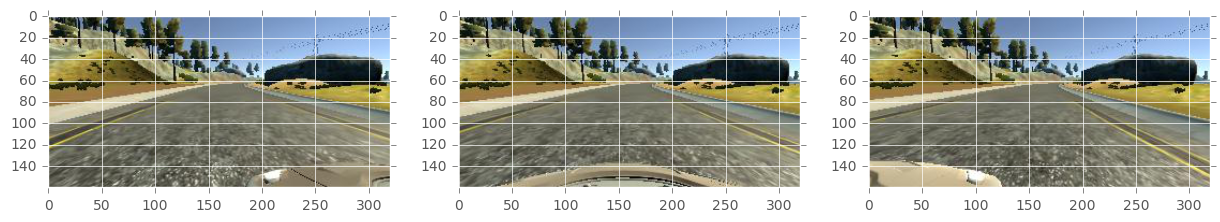

In [5]:
def show_sample(entry):
    print("Steering:", entry['steering'])
    fig = plt.figure(figsize=(15, 3))
    for i, k in enumerate(['left', 'center', 'right']):
        ax = fig.add_subplot(1,3, i + 1)
        f = os.path.join(DATA_DIR, entry[k].strip())
        img = plt.imread(f)
        ax.imshow(img)    
    plt.show()

show_sample(df.iloc[2000])

In [6]:
def image_prop(fname):
    img = plt.imread(fname)
    print(img.shape, img.dtype)
    print(img.min(), img.max())
image_prop(os.path.join(DATA_DIR, df.iloc[0]['center']))

(160, 320, 3) uint8
0 255


In [7]:
#### def process_image(img):
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:,:,0]
#     img = cv2.resize(img, (64, 32), interpolation=cv2.INTER_AREA).astype(np.float32)
#     img = (img / 255.) * 2. - 1.
#     return img, img[:,::-1]

# def process_image(img):
#     img = img[50:50 + 90, ...]
#     img = cv2.resize(img, (64, 18), interpolation=cv2.INTER_AREA).astype(np.float32)
#     img = (img / 255.)
#     return img

# def process_image(img):
#     img = cv2.resize(img, (64, 32), interpolation=cv2.INTER_AREA)
#     return img

def process_image(img):
    img = img[60:140,...]
    img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)
    return img
    
# def process_entry(entry):
#     imgs, steerings = [], []
    
#     steering = entry['steering']
#     offset = 0.2
# #     get_img = lambda f: process_image(plt.imread(os.path.join(DATA_DIR, f.strip())))
#     def fliped(f):
#         i = process_image(plt.imread(os.path.join(DATA_DIR, f.strip())))
#         return i, i[:, ::-1]
    
#     # left
#     img_orig, img_flip = fliped(entry['left'])
#     left_steer = min(steering + offset, 1.)
#     imgs.extend([img_orig, img_flip])
#     steerings.extend([left_steer, -left_steer])
    
#     # center
#     img_orig, img_flip = fliped(entry['center'])
#     imgs.extend([img_orig, img_flip])
#     steerings.extend([steering, -steering])
    
#     # right
#     img_orig, img_flip = fliped(entry['right'])
#     right_steer = max(steering - offset, -1.)
#     imgs.extend([img_orig, img_flip])
#     steerings.extend([left_steer, -left_steer])
    
#     return np.asarray(imgs)[:,:,:,None], np.asarray(steerings)

def process_entry(entry):
    imgs, steerings = [], []
    
    steering = entry['steering']
    offset = 0.25
#     get_img = lambda f: process_image(plt.imread(os.path.join(DATA_DIR, f.strip())))
    def save_images(f):
        i = process_image(plt.imread(os.path.join(DATA_DIR, f.strip())))
        
        f1 = "img_{}.jpg".format(next(img_index))
        plt.imsave(os.path.join(IMG_DIR, f1), i, vmin=0, vmax=255)
        
        i = i[:, ::-1]
        f2 = "img_{}.jpg".format(next(img_index))
        plt.imsave(os.path.join(IMG_DIR, f2), i, vmin=0, vmax=255)
        
        return f1, f2
    
    # left
    img_orig, img_flip = save_images(entry['left'])
    left_steer = min(steering + offset, 1.)
    imgs.extend([img_orig, img_flip])
    steerings.extend([left_steer, -left_steer])
    
    # center
    img_orig, img_flip = save_images(entry['center'])
    imgs.extend([img_orig, img_flip])
    steerings.extend([steering, -steering])
    
    # right
    img_orig, img_flip = save_images(entry['right'])
    right_steer = max(steering - offset, -1.)
    imgs.extend([img_orig, img_flip])
    steerings.extend([right_steer, -right_steer])
    
    return np.asarray(imgs), np.asarray(steerings)

Steering: 0.05219137
5 255
(32, 32, 3)


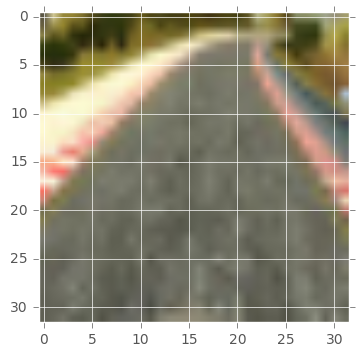

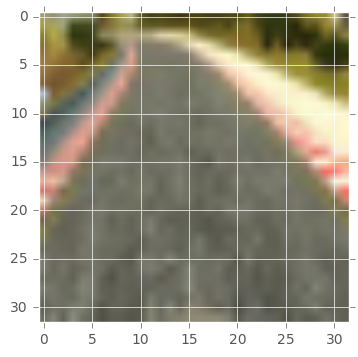

In [8]:
def show_processed():
    entry = df.iloc[1100]
    print("Steering:", entry['steering'])
    f = os.path.join(DATA_DIR, entry['center'].strip())
    img = plt.imread(f)
    img = process_image(img)
    print(img.min(), img.max())
    print(img.shape)
    plt.imshow(img)
    plt.show()
    
    img = img[:,::-1]
    plt.imshow(img)
    plt.show()
show_processed()

In [9]:

def process_data():
    X, y = [], []
    for i, r in tqdm(df.iterrows(), total=df.shape[0], desc="Processing images"):
        xx, yy = process_entry(r)
        X.append(xx)
        y.append(yy)
            
    print("Concatenating...")
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    
    print("X:", X.shape, X.dtype)
    print("y:", y.shape, y.dtype)
    
    
    print("Train-validation split...")
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.9)
    
    print("Saving...")
    np.savez(IMG_LABELS, X_train=X_train, y_train=y_train,
                                X_val=X_val, y_val=y_val)
    print("Data saved to: " + IMG_LABELS)
process_data()

Processing images: 100%|██████████| 8036/8036 [06:00<00:00, 22.79it/s]


Concatenating...
X: (48216,) <U13
y: (48216,) float64
Train-validation split...
Saving...
Data saved to: data/img_labels.npz


In [10]:
def sample_load():
    with np.load(IMG_LABELS) as f:
        X_train = f['X_train']
        y_train = f['y_train']
        X_val = f['X_val']
        y_val = f['y_val']
        
    print("\nTrain:")
    print(X_train.shape, X_train.dtype)
    print(y_train.shape, y_train.dtype, y_train.min(), y_train.max())
    img = plt.imread(os.path.join(IMG_DIR, X_train[0]))
    print("Image:", img.shape, img.dtype, img.min(), img.max())
    
    print("\nValidation:")
    print(X_val.shape, X_val.dtype)
    print(y_val.shape, y_val.dtype, y_val.min(), y_val.max())
    img = plt.imread(os.path.join(IMG_DIR, X_val[0]))
    print("Image:", img.shape, img.dtype, img.min(), img.max())
    
sample_load()


Train:
(43394,) <U13
(43394,) float64 -1.0 1.0
Image: (32, 32, 3) uint8 0 208

Validation:
(4822,) <U13
(4822,) float64 -0.8858718 1.0
Image: (32, 32, 3) uint8 0 225
